Импортируем основные модули и экспериментальные:

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, SGD, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pyplot as plt

Прописываем пути к ресурсам в таком виде, для предполагаемого "конвеерного" подхода к исследованию. Выработка некой стандартизации:

In [ ]:
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "model_01.h5"])
BASE_OUTPUT = "./output"
train_dir = './train'
val_dir = './val'
train_cats_dir = './train/cats'
train_dogs_dir = './train/dogs'
val_cats_dir = './val/cats'
val_dogs_dir = './val/dogs'

Обучение не стартует, если пользоваться следующими строками, использовать формулу для расчёта батчей тоже не получится, даже с целочисленным делением. Сам пока не разобрался почему, забиваю вручную в функцию обучения "fit".

In [ ]:
# nb_train_samples = 5760 
# nb_validation_samples = 1440
# epoc = 35
# batch_sizes = 32

Подготавливаем и разбиваем файлы на обучение и тестирование:

In [ ]:
# для обучения вписываем нескоторые варианты аугментации
train_datagen = ImageDataGenerator(
  rescale=1./255,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True)

# для тестирования только рескейл
val_datagen = ImageDataGenerator(rescale=1./255)

# генератор считывает картинки, найденные в субдиректориях train_dir,
# делит по классам и создаёт бачи с аугментированными картинками
train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(224, 224),  # должно совпадать с input_shape входного слоя Conv2D
  batch_size=32,
  class_mode='categorical')  # для categorical_crossentropy loss
  # binary не подходит - потом не получится дообучить следующую сеть на боксы

# аналогичный генератор предыдущему
val_generator = val_datagen.flow_from_directory(
  val_dir,
  target_size=(224, 224),
  batch_size=32,
  class_mode='categorical')

Found 5760 images belonging to 2 classes.
Found 1440 images belonging to 2 classes.


Формируем тело модели:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same', input_shape=(224,224,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  #tf.keras.layers.BatchNormalization(), - в текущем топовом варианте не помогают
  tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2,2),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64,(3,3),activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2,2),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64,(3,3),activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(2, activation='softmax') # sigmoid с кагла и не только не подходят,
])                                               # по той же причине, что и binary

Несколько вариантов оптимизаторов:

In [ ]:
myOpt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=3e-4, decay=0.0)
# myOpt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
# myOpt = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')
# myOpt = keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')
# myOpt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.0,)
# myOpt = keras.optimizers.RMSprop(lr=0.0001)

Расчёт модели нейросети:

In [ ]:
model.compile(
  optimizer = myOpt, 
  loss = 'categorical_crossentropy', 
  metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 64)       

Запуск обучения нейросети:

In [ ]:
history = model.fit(
  train_generator,
  validation_data = val_generator,
  validation_steps=45,
  steps_per_epoch=180,
  batch_size=32,
	epochs=30,
  verbose=1)

model.save(MODEL_PATH, save_format="h5")

Epoch 1/30
180/180 [==============================] - 896s 5s/step - loss: 0.6580 - accuracy: 0.6031 - val_loss: 0.6420 - val_accuracy: 0.6229
Epoch 2/30
180/180 [==============================] - 465s 3s/step - loss: 0.6337 - accuracy: 0.6418 - val_loss: 0.6206 - val_accuracy: 0.6687
Epoch 3/30
180/180 [==============================] - 464s 3s/step - loss: 0.6083 - accuracy: 0.6795 - val_loss: 0.5849 - val_accuracy: 0.6854
Epoch 4/30
180/180 [==============================] - 476s 3s/step - loss: 0.5724 - accuracy: 0.7056 - val_loss: 0.5788 - val_accuracy: 0.7208
Epoch 5/30
180/180 [==============================] - 470s 3s/step - loss: 0.5652 - accuracy: 0.7127 - val_loss: 0.6096 - val_accuracy: 0.6785
Epoch 6/30
180/180 [==============================] - 471s 3s/step - loss: 0.5453 - accuracy: 0.7260 - val_loss: 0.5256 - val_accuracy: 0.7444
Epoch 7/30
180/180 [==============================] - 471s 3s/step - loss: 0.5152 - accuracy: 0.7514 - val_loss: 0.5281 - val_accuracy: 0.7319

Собираем статистику:

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

Рисуем графики accuracy:

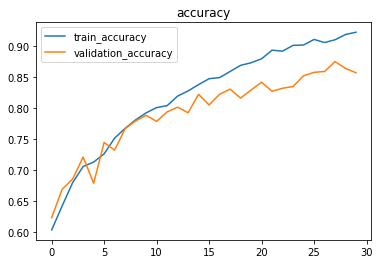

In [ ]:
plt.plot(epochs,acc,label='train_accuracy')
plt.plot(epochs,val_acc,label='validation_accuracy')
plt.title('accuracy')
plt.legend()

Рисуем графики loss:

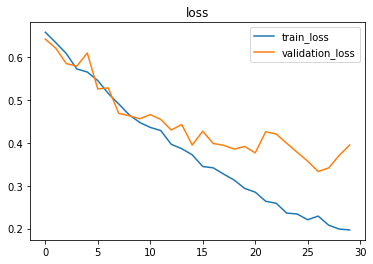

In [ ]:
plt.plot(epochs,loss,label='train_loss')
plt.plot(epochs,val_loss,label='validation_loss')
plt.title('loss')
plt.legend()

Выдох..